## Notebook to calculate Sobol indices for performing model parameter sensitivity analysis

### Model: PLSR
### Property: Coulombic efficiency

**Created on 15th December, 2023; modified on 13th February, 2024**

In [3]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/sensitivity-analysis/coulombic-efficiency
total 656
-rw-------@ 1 riteshk  staff  136133 Feb  4 16:31 plsr_model_strat_ncomp_11_fold_5.sav
-rw-------@ 1 riteshk  staff  136133 Feb  4 16:31 plsr_model_strat_ncomp_11_fold_4.sav
-rw-------@ 1 riteshk  staff  136133 Feb  4 16:31 plsr_model_strat_ncomp_11_fold_3.sav
-rw-------@ 1 riteshk  staff  135957 Feb  4 16:31 plsr_model_strat_ncomp_11_fold_2.sav
-rw-------@ 1 riteshk  staff  135957 Feb  4 16:31 plsr_model_strat_ncomp_11_fold_1.sav
-rw-------@ 1 riteshk  staff  126844 Feb  4 16:38 strat_rs30_val_gr_comb_add.csv
-rw-------@ 1 riteshk  staff  900246 Feb  4 16:38 strat_rs30_train_gr_comb_add.csv
-rw-------@ 1 riteshk  staff  126821 Feb  4 16:38 strat_rs30_test_gr_comb_add.csv
-rw-r--r--@ 1 riteshk  staff  169749 Feb 13 14:50 sobol_analysis_ce_stratII_plsr.ipynb
-rw-------@ 1 riteshk  staff  172291 Feb 13 14:51 sobol_analysis_ce_stratII_plsr_m3

In [4]:
import numpy as np
# from keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import os, sys
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Draw, PandasTools
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import dask
import dask.array
from dask import delayed
from dask.distributed import Client

In [4]:
# path = '/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/coulombic-efficiency_1.1/using-pretrainedGR/gr-embed-200/common-log-output/stratified-split-2-cv/' ## on MacBook Pro

In [2]:
val_df = pd.read_csv('strat_rs30_val_gr_comb_add.csv')
# train_df = pd.read_csv(path + 'strat_rs30_train_gr_comb_add.csv')
train_df = pd.read_csv('strat_rs30_train_gr_comb_add.csv')
test_df = pd.read_csv('strat_rs30_test_gr_comb_add.csv')
train_df

,solv_smile_comb,salt_smile_comb,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,...,solv_ratio_3,mw_salt_1,mw_salt_2,salt_1_conc,salt_2_conc,mw_add,protocol,current_density,log(1-CE),CE_binned
0,C1COCO1.COCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=S(=O)([N-]S(=...,-0.006039,-0.004283,-0.013746,-0.005626,-0.005084,-0.004713,-0.006876,0.033564,...,0.0,186.939685,286.933298,0.50,0.5,0.000000,3,0.25,-2.000000,2
1,COCCOCCOCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=C1OCCO1,-0.005236,0.010172,-0.012011,-0.008903,-0.006002,-0.005831,-0.007050,0.042227,...,0.0,186.939685,0.000000,3.00,0.0,88.016044,1,0.40,-1.443697,3
2,O=C1OCCO1.CCOC(=O)OCC,[Li+].[O-][Cl+3]([O-])([O-])[O-],0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.0,105.964516,0.000000,1.00,0.0,0.000000,1,1.00,-0.856985,5
3,O=C1OCC(F)O1.COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.137776,0.012570,-0.012399,0.089359,-0.008272,-0.005663,0.001472,0.037405,...,0.0,186.939685,0.000000,1.00,0.0,0.000000,4,1.00,-0.918653,4
4,CCCCOCCCC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.006658,0.133333,-0.013576,-0.009701,0.071500,-0.006591,-0.007900,0.008567,...,0.0,186.939685,0.000000,2.00,0.0,0.000000,4,0.50,-2.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,COCCCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.005567,0.036068,-0.012261,-0.009823,-0.004649,-0.006229,-0.007929,-0.004282,...,0.0,186.939685,0.000000,1.00,0.0,0.000000,2,0.50,-1.638272,3
108,O=C1OCCO1.CCOC(=O)OCC,F[P-](F)(F)(F)(F)F.[Li+].O=C1OCC(F)O1,0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.0,151.980186,0.000000,1.00,0.0,106.006622,3,0.50,-1.301030,4
109,CCOCC.C1CCOC1,F[As-](F)(F)(F)(F)F.[Li+],-0.007749,0.035542,-0.014806,-0.008115,-0.005807,-0.005667,-0.008082,0.008053,...,0.0,195.928020,0.000000,2.50,0.0,0.000000,2,5.00,-1.657577,3
110,COC(=O)OCC(F)(F)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.122961,-0.008040,-0.009732,-0.003611,-0.012537,-0.005110,-0.008643,-0.008926,...,0.0,186.939685,0.000000,3.16,0.0,0.000000,2,0.50,-1.275724,4


In [4]:
df_all = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)

In [ ]:
# train_df.drop(columns=['fr_func_grp_11_salt'], inplace=True)
# val_df.drop(columns=['fr_func_grp_11_salt'], inplace=True)
# test_df.drop(columns=['fr_func_grp_11_salt'], inplace=True)

In [4]:
# df_all = pd.concat([train_df, val_df, test_df])
# df_all.drop(columns=['fr_func_grp_20_salt'], inplace=True)
# train_df.drop(columns=['fr_func_grp_20_salt'], inplace=True)
# val_df.drop(columns=['fr_func_grp_20_salt'], inplace=True)
# test_df.drop(columns=['fr_func_grp_20_salt'], inplace=True)

In [5]:
X_train = train_df.iloc[:,2:-2]
y_train = train_df.iloc[:,-2]

X_test = test_df.iloc[:,2:-2]
y_test = test_df.iloc[:,-2]

X_val = val_df.iloc[:,2:-2]
y_val = val_df.iloc[:,-2]

X_all = df_all.iloc[:,2:-2]
y_all = df_all.iloc[:,-2]

## scaling the data
scaler = MinMaxScaler().fit(X_train.iloc[:,-13:])
X_train_scaled = scaler.transform(X_train.iloc[:,-13:])
X_train_ = np.concatenate((X_train.iloc[:,:-13], X_train_scaled), axis=1)
X_val_scaled = scaler.transform(X_val.iloc[:,-13:])
X_val_ = np.concatenate((X_val.iloc[:,:-13], X_val_scaled), axis=1)
X_test_scaled = scaler.transform(X_test.iloc[:,-13:])
X_test_ = np.concatenate((X_test.iloc[:,:-13], X_test_scaled), axis=1)
X_all_scaled = scaler.transform(X_all.iloc[:,-13:])
X_all_ = np.concatenate((X_all.iloc[:,:-13], X_all_scaled), axis=1)

In [6]:
X_train_.shape
# X_train.columns.to_list()

(112, 413)

In [7]:
plsr_models = []
for i in range(1,6):
#     filename = path + f'plsr_model_strat_ncomp_11_fold_{i}.sav'
    filename = f'plsr_model_strat_ncomp_11_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    plsr_models.append(loaded_model)

In [7]:
# X_train_[:,0].min()
# X_train_[:,30].max()
# X_train_[:,30].std()

1.0

In [8]:
## generate a list of max and min of each feature in the form [[min1, max1], [min2, max2], ...]
min_max = []
# for i in range(X_train_.shape[1]):
for i in range(X_all_.shape[1]):
    min_max.append([X_all_[:,i].min(), X_all_[:,i].max()])
    # min_max.append([X_train_[:,i].min(), X_train_[:,i].max()])
min_max

[[-0.0085803540423512, 0.2604894638061523],
 [-0.0080699361860752, 0.1896896660327911],
 [-0.0170832592993974, -0.007889081723988],
 [-0.0108057577162981, 0.1748049408197403],
 [-0.0169442389160394, 0.071499727666378],
 [-0.0094201704487204, 0.1888885200023651],
 [-0.0146458419039845, 0.0659624859690666],
 [-0.0099207535386085, 0.0944923534989357],
 [-0.0143468584865331, 0.0501427948474884],
 [-0.0135674020275473, 0.0579287521541118],
 [-0.006935485638678, 0.3691995143890381],
 [-0.0193333197385072, 0.0778744146227836],
 [-0.0104544749483466, 0.055279366672039],
 [-0.0180965792387723, 0.0166836157441139],
 [-0.0104321734979748, 0.0821961537003517],
 [-0.0224711839109659, 0.152920052409172],
 [-0.0098146377131342, 0.0653850883245468],
 [-0.0129448501393198, 0.2130493372678756],
 [-0.0123785817995667, 0.1463791131973266],
 [-0.0147772664204239, -0.000679925084114],
 [-0.0186363197863101, 0.0755853503942489],
 [-0.0146863684058189, -0.0051305280067026],
 [-0.0170879941433668, 0.0579291731

In [9]:
# Define the problem for sensitivity analysis
problem = {
    'num_vars': plsr_models[0].n_features_in_,  # Number of features in the model
    'names': X_train.columns.to_list(),  # Feature names
    'bounds': min_max  # feature range
}

<AxesSubplot: >

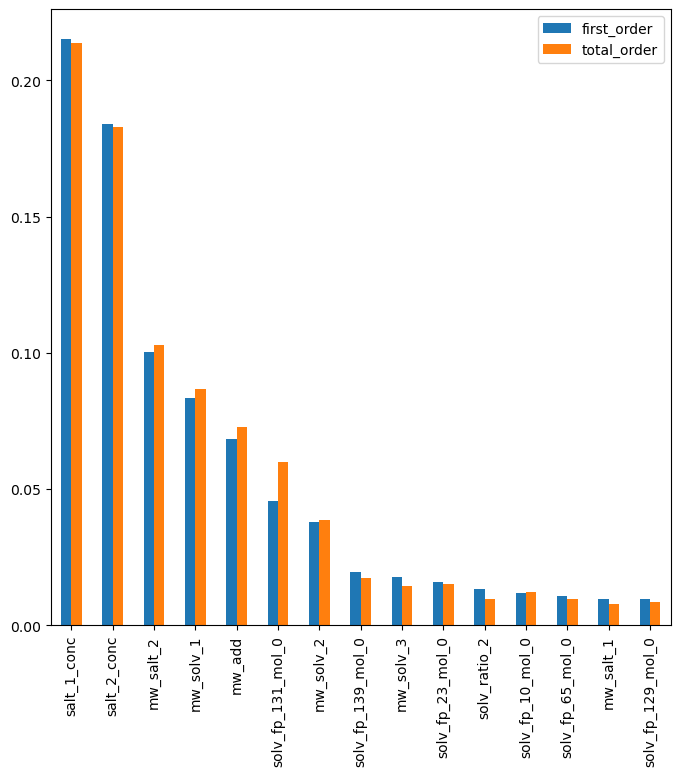

In [36]:
# ## bar plot of both first-order & total Sobol indices for first 15 features in df_sobol
# df_sobol.iloc[:15,:].plot.bar(rot=90, figsize=(8,8))

**Average of all five models**

In [ ]:
first_order_sobol = []
total_order_sobol = []

# Create a Dask client with 4 workers
client = Client(n_workers=16)

# Generate samples
param_values = saltelli.sample(problem, 2**10)
print('sample generation done...')

count = 0
for model in plsr_models:
    # Evaluate the model for each sample
    predictions = []
    for params in param_values:
        prediction = model.predict(np.array([params]))
        if np.isscalar(prediction):
            predictions.append(prediction)
        else:
            predictions.append(prediction[0])

    predictions = np.array(predictions)

    # Perform Sobol analysis
    sobol_analysis = sobol.analyze(problem, predictions.ravel())
    print('Sobol analsis done for model: ', count)
    count += 1

    # Store the first-order and total-order Sobol indices
    first_order_sobol.append(sobol_analysis['S1'])
    total_order_sobol.append(sobol_analysis['ST'])

# Convert the lists to NumPy arrays
first_order_sobol = np.array(first_order_sobol)
total_order_sobol = np.array(total_order_sobol)

# Compute the average and standard deviation
avg_first_order_sobol = np.mean(first_order_sobol, axis=0)
std_first_order_sobol = np.std(first_order_sobol, axis=0)
avg_total_order_sobol = np.mean(total_order_sobol, axis=0)
std_total_order_sobol = np.std(total_order_sobol, axis=0)

# Create a DataFrame with the results
df_sobol = pd.DataFrame({
    'feature': problem['names'],
    'avg_first_order': avg_first_order_sobol,
    'std_first_order': std_first_order_sobol,
    'avg_total_order': avg_total_order_sobol,
    'std_total_order': std_total_order_sobol,
})

# Set the feature names as the index
df_sobol.set_index('feature', inplace=True)

# Now you can plot the results with error bars
df_sobol[['avg_first_order', 'avg_total_order']].plot.bar(yerr=df_sobol[['std_first_order', 'std_total_order']], rot=90, figsize=(8,8))

In [12]:
param_values

array([[-0.00818621,  0.0663796 , -0.01296653, ...,  0.1001357 ,
         0.29443359,  0.18212891],
       [-0.00818621,  0.0663796 , -0.01296653, ...,  0.1001357 ,
         0.29443359,  0.18212891],
       [-0.00818621,  0.00264848, -0.01296653, ...,  0.1001357 ,
         0.29443359,  0.18212891],
       ...,
       [ 0.18231732,  0.11408138, -0.01552546, ...,  0.770233  ,
         0.60791016,  0.34423828],
       [ 0.18231732,  0.11408138, -0.01552546, ...,  0.770233  ,
         0.85986328,  0.41357422],
       [ 0.18231732,  0.11408138, -0.01552546, ...,  0.770233  ,
         0.85986328,  0.34423828]])

In [14]:
df_sobol

,avg_first_order,std_first_order,avg_total_order,std_total_order
feature,,,,
solv_fp_0_mol_0,0.007808,3.806532e-03,9.617338e-03,4.012320e-03
solv_fp_1_mol_0,0.001058,7.036165e-04,1.210023e-03,7.446482e-04
solv_fp_2_mol_0,-0.000001,1.353905e-07,7.898179e-09,3.349983e-09
solv_fp_3_mol_0,0.000244,2.280210e-04,2.775681e-04,2.254209e-04
solv_fp_4_mol_0,0.000083,7.956950e-05,1.743351e-05,1.696209e-05
...,...,...,...,...
salt_1_conc,0.278021,1.027158e-01,2.725903e-01,1.021767e-01
salt_2_conc,0.083609,6.603627e-02,8.349238e-02,6.533655e-02
mw_add,0.021453,2.498363e-02,2.537190e-02,2.601434e-02


In [15]:
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
# purple = (0.839, 0.286, 0.604) # 214, 73, 1541
anvil = (0.298, 0.78, 0.77) # 76, 199, 196

In [26]:
df_sobol.to_csv('sobol_analysis_plsr_ce_strat2.csv')

In [1]:
## plotting on local computer (MacBook Pro)
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
anvil = (0.298, 0.78, 0.77) # 76, 199, 196

In [5]:
df_sobol = pd.read_csv('sobol_analysis_plsr_ce_strat2.csv')
df_sobol

,feature,avg_first_order,std_first_order,avg_total_order,std_total_order
0,solv_fp_0_mol_0,0.007808,3.806532e-03,9.617338e-03,4.012320e-03
1,solv_fp_1_mol_0,0.001058,7.036165e-04,1.210023e-03,7.446482e-04
2,solv_fp_2_mol_0,-0.000001,1.353905e-07,7.898179e-09,3.349983e-09
3,solv_fp_3_mol_0,0.000244,2.280210e-04,2.775681e-04,2.254209e-04
4,solv_fp_4_mol_0,0.000083,7.956950e-05,1.743351e-05,1.696209e-05
...,...,...,...,...,...
408,salt_1_conc,0.278021,1.027158e-01,2.725903e-01,1.021767e-01
409,salt_2_conc,0.083609,6.603627e-02,8.349238e-02,6.533655e-02
410,mw_add,0.021453,2.498363e-02,2.537190e-02,2.601434e-02
411,protocol,0.011437,9.690647e-03,9.630613e-03,8.267208e-03


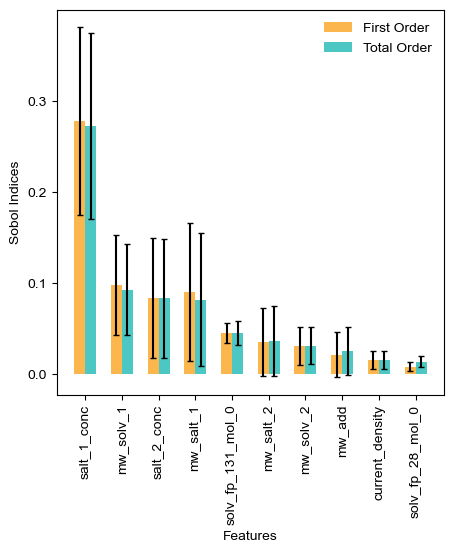

In [7]:
# Plotting Sobol indices for top 10 features having highest total order indices
df_sobol_ = df_sobol.sort_values(by='avg_total_order', ascending=False).iloc[:10,:]
features = df_sobol_['feature']
avg_first_order = df_sobol_['avg_first_order']
std_first_order = df_sobol_['std_first_order']
avg_total_order = df_sobol_['avg_total_order']
std_total_order = df_sobol_['std_total_order']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(5, 5))

# Set the bar width
bar_width = 0.3

# Set the opacity
opacity = 1.0

# Plot the first order Sobol indices
rects1 = ax.bar(np.arange(len(features)) - bar_width/2, avg_first_order, bar_width, alpha=opacity, color=orange, yerr=std_first_order, label='First Order', capsize=2)

# Plot the total order Sobol indices
rects2 = ax.bar(np.arange(len(features)) + bar_width/2, avg_total_order, bar_width, alpha=opacity, color=anvil, yerr=std_total_order, label='Total Order', capsize=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Features')
ax.set_ylabel('Sobol Indices')
# ax.set_title('Sobol Indices by Feature')
ax.set_yticks([0.0, 0.1, 0.2, 0.3])
ax.set_yticklabels([0.0, 0.1, 0.2, 0.3])
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.legend(frameon=False)

# Show the plot
# plt.show()
plt.savefig('plot_sobol_analysis_plsr_ce_strat2.eps', dpi=300)

<AxesSubplot:xlabel='feature'>

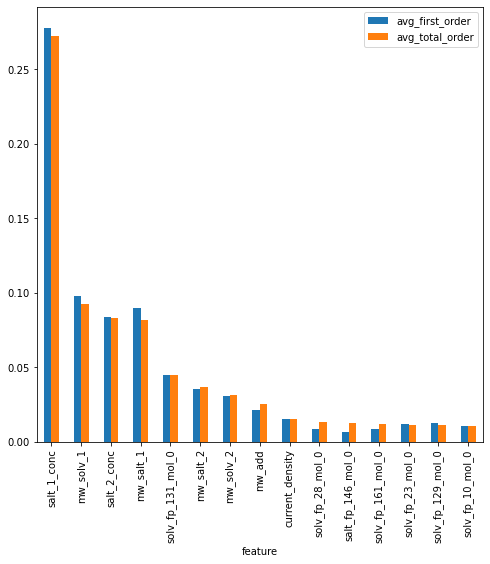

In [25]:
# df_ = df_sobol.sort_values(by='avg_total_order', ascending=False).iloc[:15,:]
# df_[['avg_first_order', 'avg_total_order']].plot.bar(yerr=df_[['std_first_order', 'std_total_order']], rot=90, figsize=(8,8))